<a href="https://colab.research.google.com/github/Pranavjeet-Naidu/N-Beats-Replication/blob/main/io_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
#helper functions
def get_labelled_windows(x, horizon=1):
    return x[:,:-horizon], x[:, -horizon:]


def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

def mean_absolute_scaled_error(y_true, y_pred):
    '''
    No seasonality is assumed
    '''
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
        plt.grid(True)

def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

def make_preds(model, data):
    return tf.squeeze(model.predict(data))

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-04-05 19:22:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-04-05 19:22:04 (6.91 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#ARIMA


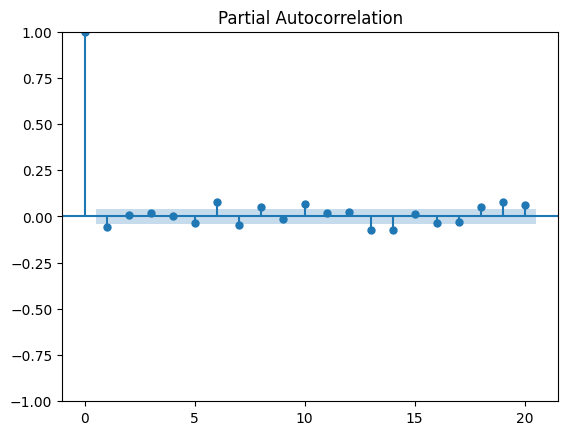

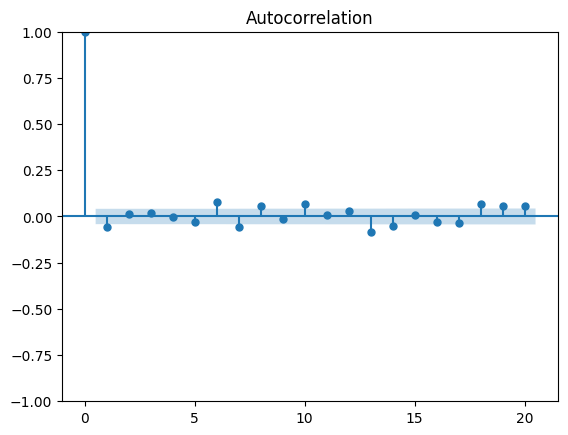

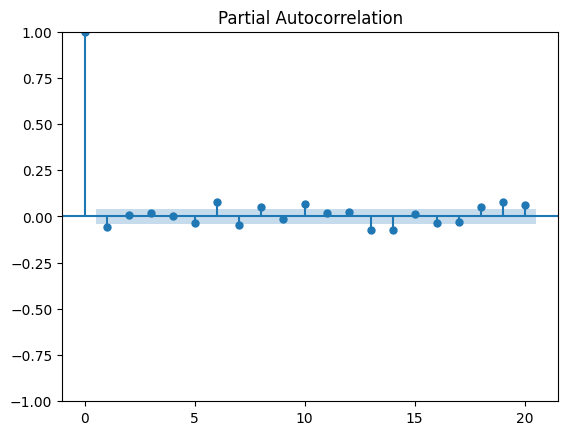

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

# Load the dataset
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

# Split the data into training and test sets
split_size = int(len(bitcoin_prices) * 0.8)
X_train, y_train = bitcoin_prices[:split_size], bitcoin_prices["Price"][:split_size]
X_test, y_test = bitcoin_prices[split_size:], bitcoin_prices["Price"][split_size:]

# Select a single column from X_train
column_name = 'Price'
X_train_single_column = X_train[column_name]

# Calculate ACF and PACF for the selected column
lag_acf = acf(X_train_single_column.diff().dropna(), nlags=20)
lag_pacf = pacf(X_train_single_column.diff().dropna(), nlags=20, method='ols')

# Plot ACF and PACF
plot_acf(X_train_single_column.diff().dropna(), lags=20)
plot_pacf(X_train_single_column.diff().dropna(), lags=20)


In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

# Split the data into training and test sets
split_size = int(len(bitcoin_prices) * 0.8)
X_train, y_train = bitcoin_prices[:split_size], bitcoin_prices["Price"][:split_size]
X_test, y_test = bitcoin_prices[split_size:], bitcoin_prices["Price"][split_size:]

# Define the range of values for p, d, q
p_values = range(0, 3)  # AR order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 3)  # MA order

best_aic = float("inf")
best_params = None

# Iterate over all possible combinations of p, d, q
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit ARIMA model
        model = ARIMA(X_train, order=(p, d, q))
        model_fit = model.fit()

        # Calculate AIC
        aic = model_fit.aic

        # Update best parameters if AIC is lower
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
    except:
        continue

print("Best ARIMA parameters:", best_params)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best ARIMA parameters: (2, 1, 2)


In [ ]:
# Common ARIMA parameters
p = 2 # AR order
d = 1  # Differencing order
q = 2  # MA order

X_train.index.freq = 'D'
model = ARIMA(X_train, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Mean Absolute Error: 11706.2270662166
Mean Squared Error: 421454844.96718365


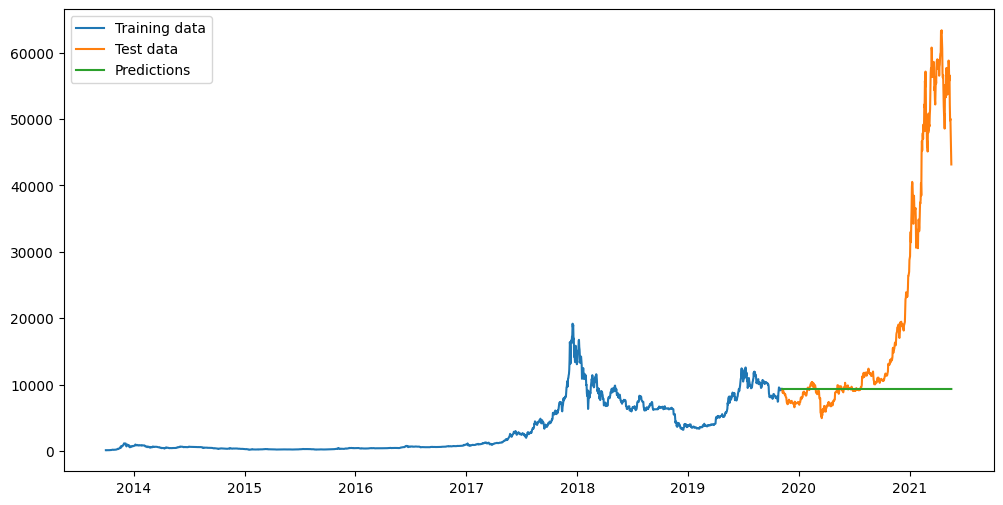

In [ ]:
# Make predictions
start_idx = len(X_train)
end_idx = start_idx + len(X_test) - 1
predictions = model_fit.predict(start=start_idx, end=end_idx, typ='levels')

# Calculate Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training data')
plt.plot(y_test.index, y_test, label='Test data')
plt.plot(y_test.index, predictions, label='Predictions')
plt.legend()
plt.show()



#REPLICATION OF NBEATS

In [ ]:
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
import matplotlib.pyplot as plt
timestamps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"]  = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Let's make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

In [ ]:
# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create N-BEATS custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # The **kwargs argument takes care of all the arguments for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers, each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of the block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
WINDOW_SIZE = 7
HORIZON = 1
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.34270036 -0.6100718   0.6462741  -0.92755    -1.0818543   0.26608017
  0.07811789]
Forecast: -0.7520043253898621


In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])
# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of N-BEATS block
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

CPU times: user 9.34 ms, sys: 0 ns, total: 9.34 ms
Wall time: 37.1 ms


In [ ]:
# 2. Create an input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

In [ ]:
# 3. Create initial backcast and forecast (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

In [ ]:
# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in #3
  # 5.  Use the NBeatsBlock to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals
     # 6. Create double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

In [ ]:
# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

In [ ]:
# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
# 9. Fit the model with EarlyStopping and ReduceLRonPlateau callabcks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=200,
                                                 verbose=1,
                                                 min_lr=1e-7)])

Epoch 1/5000
3/3 [==============================] - 53s 997ms/step - loss: 5783.9722 - val_loss: 8787.4600 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 97ms/step - loss: 1253.3088 - val_loss: 16055.1455 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 71ms/step - loss: 2443.4976 - val_loss: 11240.7666 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 149ms/step - loss: 1056.4083 - val_loss: 3458.4421 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 71ms/step - loss: 788.8551 - val_loss: 4527.5503 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 161ms/step - loss: 1835.7257 - val_loss: 1500.9670 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 71ms/step - loss: 888.2974 - val_loss: 3255.9573 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 77ms/step - loss: 249.7130 - val_loss: 4717.9126 - lr: 0.0010
Epoch 9/5000
3/3 [==============================] - 0

In [ ]:
# Evaluate N-BEATS model on the test dataset

model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 34ms/step - loss: 573.9424


573.9423828125

In [ ]:
# Make predictions with the N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8876.655 , 8807.695 , 9039.131 , 8776.865 , 8745.537 , 8754.006 ,
       8680.2295, 8524.967 , 8481.106 , 8529.044 ], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 573.9424,
 'mse': 1175298.6,
 'rmse': 1084.1119,
 'mape': 2.6146095,
 'mase': 1.0082577}

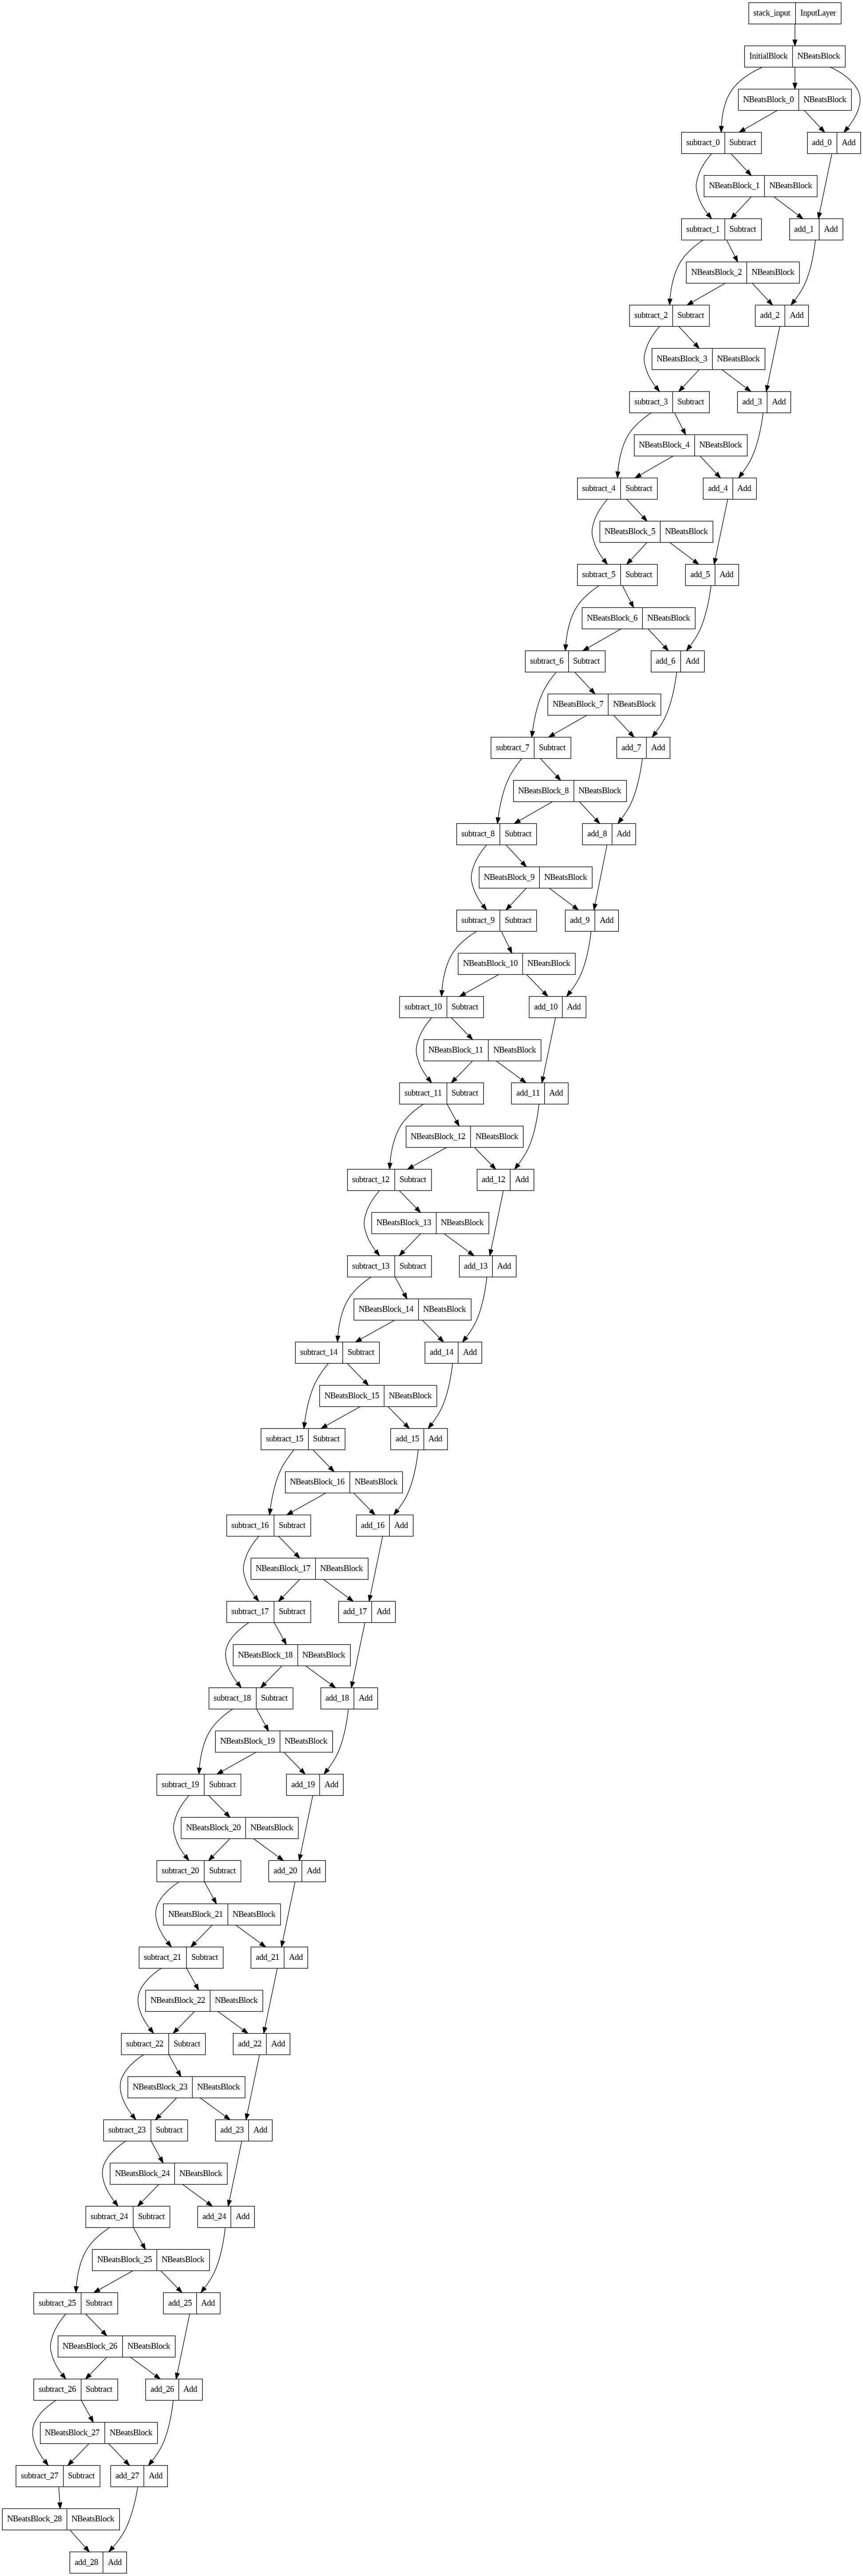

In [ ]:
# Plot the N-BEATS
from tensorflow.keras.utils import plot_model
plot_model(model_7)